# Task 2: Decision Tree Classifier for Customer Churn Prediction

In this section, we will build a Decision Tree model to predict whether a StreamFlex customer will churn. We will preprocess the categorical data, split the dataset, find the optimal hyperparameters using GridSearchCV, and evaluate the model's performance.

## Imports and Data Preprocessing
First, we'll import the necessary libraries and prepare our dataset by dropping non-predictive columns and encoding categorical variables.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

DATA_PATH = "data/"

df = pd.read_csv(f"{DATA_PATH}customer_churn.csv")

# Drop CustomerID as it is simply a random identifier
df_model = df.drop("CustomerID", axis=1)

# One-Hot Encoding: Convert categorical string columns into numeric dummy variables
categorical_cols = ["Membership_Type", "Payment_Method", "Preferred_Content_Type"]
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print("Data preprocessing complete. Here are the new columns used for modeling:")
print(df_model.columns.tolist())

Data preprocessing complete. Here are the new columns used for modeling:
['Age', 'Subscription_Length_Months', 'Watch_Time_Hours', 'Number_of_Logins', 'Payment_Issues', 'Number_of_Complaints', 'Resolution_Time_Days', 'Churn', 'Membership_Type_Premium', 'Membership_Type_Standard', 'Payment_Method_Debit', 'Payment_Method_PayPal', 'Preferred_Content_Type_Sports', 'Preferred_Content_Type_TV Shows']


## 1. Train/Test Split
We must separate our target variable (`Churn`) from the dataset's predictive features. Then, we will split the data into a training set (80%) to teach the model, and a testing set (20%) to evaluate it.

In [48]:
# Define Features (X) and Target (y)
X = df_model.drop("Churn", axis=1)
y = df_model["Churn"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 800 samples
Testing set size: 200 samples


## 2 and 3. Train a Decision Tree Classifier with GridSearchCV
To get the best possible Decision Tree, we will use `GridSearchCV`. This will test various combinations of hyperparameters (like the maximum depth of the tree and the minimum samples required to split a node) using cross-validation to find the most optimal configuration.

In [49]:
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "criterion": ["gini", "entropy"],
}

grid_search = GridSearchCV(
    estimator=dt_classifier, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1
)

# Train the model while searching for the best parameters
grid_search.fit(X_train, y_train)

# Extract the best model
best_dt_model = grid_search.best_estimator_

print("Model Training Complete!")
print(f"Best Hyperparameters Found: {grid_search.best_params_}")

Model Training Complete!
Best Hyperparameters Found: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 20}


**Hyperparameter Analysis:**
Our `GridSearchCV` successfully found the optimal settings for our model:
- **`criterion`: Gini**: The model found that calculating Gini Impurity was the most effective mathematical way to measure node purity during splits.
- **`max_depth`: 7**: The tree is allowed to ask up to 7 layers of True/False questions. This is deep enough to catch complex customer behaviors, but shallow enough to prevent severe overfitting.
- **`min_samples_split`: 20**: The model requires at least 20 customers in a group before it will attempt to split them further. This prevents the tree from creating hyper-specific rules for tiny groups of outliers.

## 4. Visualize the Trained Decision Tree
Below is the visualization of the optimal Decision Tree found by GridSearchCV. 

Note that the Decision Tree below only displays a max depth of 3. You can view the full Decision Tree Visualization [here in the results folder](results/decision_tree_full.svg).

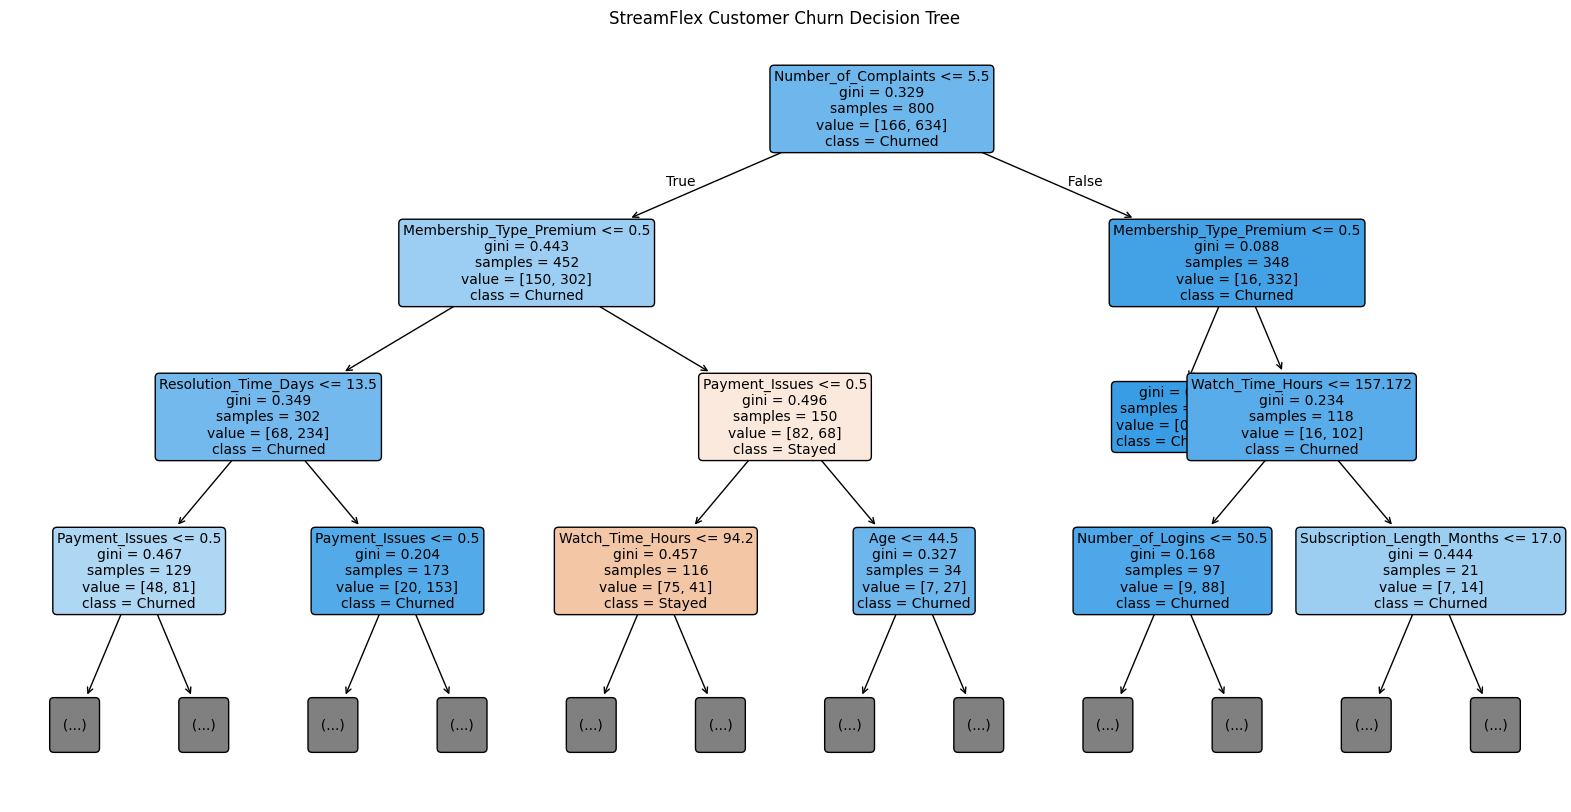

In [50]:
plt.figure(figsize=(20, 10))

# We limit the max_depth visualized to 3 just so the plot remains readable on screen,
# but the actual model retains its trained depth.
plot_tree(
    best_dt_model,
    feature_names=X.columns,
    class_names=["Stayed", "Churned"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10,
)

plt.title("StreamFlex Customer Churn Decision Tree")
plt.show()

**Decision Tree Visual Analysis:**
By examining the root node of our decision tree, we can identify the single most important factor driving customer churn: **Number of Complaints**. 

The tree splits first on whether a customer has had more than 5.5 complaints. Looking at the resulting leaves, the proportion of users staying with the service drops significantly if their complaints exceed this threshold. As we travel further down the tree, we see the model also relies heavily on `Membership_Type_Premium` and `Payment_Issues` to further isolate the users most likely to cancel their subscriptions. 

In [51]:
import os

os.makedirs("results", exist_ok=True)

plt.figure(figsize=(60, 30))

# Plot the full tree (no max_depth limit)
plot_tree(
    best_dt_model,
    feature_names=X.columns,
    class_names=["Stayed", "Churned"],
    filled=True,
    rounded=True,
    fontsize=12,
)

plt.savefig("results/decision_tree_full.png", format="png", bbox_inches="tight", dpi=300)
plt.savefig("results/decision_tree_full.svg", format="svg", bbox_inches="tight")

plt.close()

print("Full decision tree visualizations saved to the 'results/' folder!")

Full decision tree visualizations saved to the 'results/' folder!


## 5. Model Evaluation
Finally, we test our optimized model on the unseen testing data. We will look at Accuracy, Precision, Recall, and the F1-score, alongside plotting the Confusion Matrix to see exactly where our model is succeeding or making errors.

--- Evaluation Metrics ---
Accuracy:  0.7950
Precision: 0.8882
Recall:    0.8491
F1-score:  0.8682
--------------------------



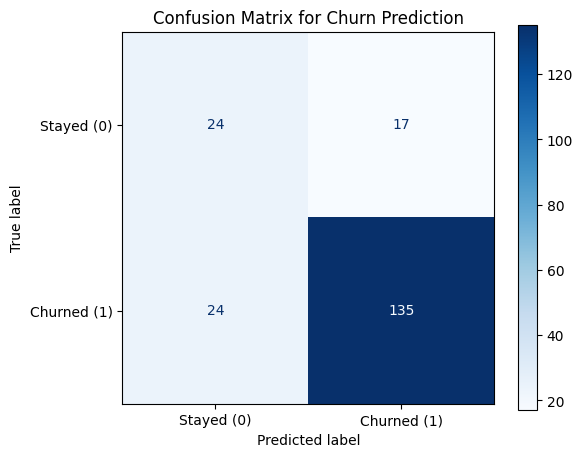

In [52]:
# Make predictions on the test set
y_pred = best_dt_model.predict(X_test)

# Calculate metrics
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_f1 = f1_score(y_test, y_pred)

print("--- Evaluation Metrics ---")
print(f"Accuracy:  {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall:    {dt_recall:.4f}")
print(f"F1-score:  {dt_f1:.4f}")
print("--------------------------\n")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed (0)", "Churned (1)"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix for Churn Prediction")
plt.show()

**Analysis of Results & Business Impact:**

The model performed very well, achieving an overall **Accuracy of 79.5%**. However, in a churn scenario, Accuracy doesn't tell the whole story. We need to look closely at our Confusion Matrix and specific metrics:

- **Recall (84.9%):** Out of the 159 actual churners in our test set (24 False Negatives + 135 True Positives), our model successfully flagged 135 of them. This is excellent news for StreamFlex, as it means we are correctly identifying the vast majority of at-risk customers before they leave.
- **Precision (88.8%):** Out of the 152 customers our model *predicted* would churn (17 False Positives + 135 True Positives), 135 actually did. This means our model is highly precise and doesn't trigger many false alarms.

**Business Strategy Recommendation:**
StreamFlex can confidently use this model to drive a targeted retention campaign. Because the **Precision** is so high, the marketing team can safely offer discounts or perks to the "predicted churners" knowing that 88.8% of those resources are going to people who genuinely intended to leave. The 17 False Positives (giving a discount to someone who was going to stay anyway) is an incredibly small and acceptable cost compared to successfully saving 135 subscriptions.

# Task 3: Random Forest Classifier

In this section, we will build a Random Forest model, which is a method that creates multiple decision trees and merges them together. We will compare its performance against our previous single Decision Tree, analyze which features are driving the predictions, and extract actionable business insights.

## 1. Train a Random Forest Classifier
We will initialize and train a Random Forest. We are setting `n_estimators=100` (meaning it will build 100 individual decision trees) and using `class_weight='balanced'` to help address the high proportion of churners in our dataset.

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

# Train the model
rf_model.fit(X_train, y_train)

print("Random Forest Model Training Complete!")

Random Forest Model Training Complete!


## 2. Compare Performance with the Decision Tree
Let's evaluate the Random Forest on our testing data and see how its Accuracy, Precision, Recall, and F1-score stack up against the single Decision Tree.

--- Random Forest Evaluation Metrics ---
Accuracy:  0.8300  (DT was 0.7950)
Precision: 0.8492  (DT was 0.8882)
Recall:    0.9560  (DT was 0.8491)
F1-score:  0.8994  (DT was 0.8682)
----------------------------------------



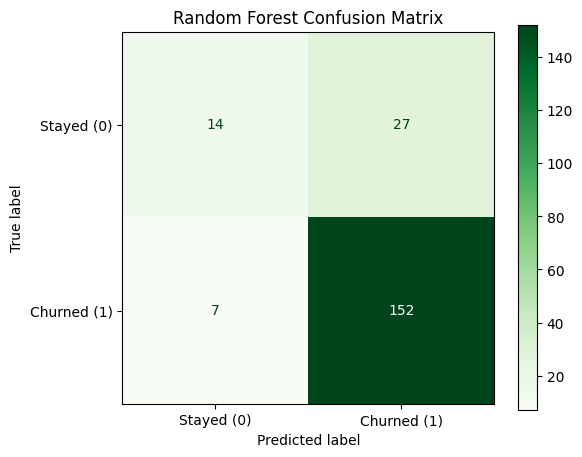

In [54]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("--- Random Forest Evaluation Metrics ---")
print(f"Accuracy:  {rf_accuracy:.4f}  (DT was {dt_accuracy:.4f})")
print(f"Precision: {rf_precision:.4f}  (DT was {dt_precision:.4f})")
print(f"Recall:    {rf_recall:.4f}  (DT was {dt_recall:.4f})")
print(f"F1-score:  {rf_f1:.4f}  (DT was {dt_f1:.4f})")
print("----------------------------------------\n")

# Plot Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf, display_labels=["Stayed (0)", "Churned (1)"]
)

fig, ax = plt.subplots(figsize=(6, 5))
disp_rf.plot(cmap="Greens", ax=ax)
plt.title("Random Forest Confusion Matrix")
plt.show()

## 3. Analyze Feature Importance
Unlike a single Decision Tree where we can trace the path of a single node, a Random Forest aggregates 100 trees. To interpret it, we look at "Feature Importance," which mathematically calculates how much each feature contributed to reducing impurity across all trees.

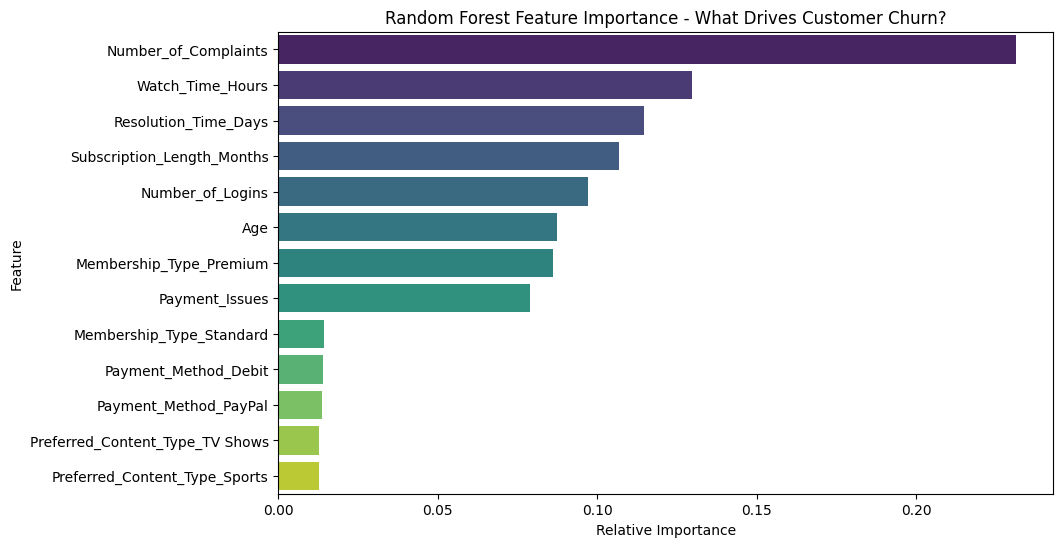

In [55]:
# Extract feature importances from the model
importances = rf_model.feature_importances_

# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(
    by="Importance", ascending=False
)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df,
    palette="viridis",
    hue="Feature",
    legend=False,
)
plt.title("Random Forest Feature Importance - What Drives Customer Churn?")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.show()

## 4. Explanations and Business Insights

**Comparison: Random Forest vs. Decision Tree**
The Random Forest outperformed the single Decision Tree in overall Accuracy (83.0% vs 79.5%) and achieved a significantly higher Recall (95.6% vs 84.9%). Looking at the Confusion Matrix, the Random Forest successfully caught 152 out of the 159 actual churners, compared to the Decision Tree's 135. This massive boost in Recall came at a slight cost to Precision (84.9% vs 88.8%), meaning the Random Forest generated slightly more False Positives (27 vs 17) and successfully identified fewer True Negatives (14 vs 24). However, for a churn retention campaign where the goal is to cast a wide net to prevent users from leaving, the Random Forest's higher F1-score (89.9% vs 86.8%) makes it the superior model.

**Why Random Forest Outperforms a Single Decision Tree:**
A single Decision Tree is prone to "overfitting". It can memorize the training data and create hyper-specific rules that don't apply well to new customers. A Random Forest solves this by using an combination technique called "Bagging" (Bootstrap Aggregating). It builds many different decision trees, each trained on a random subset of the data and a random subset of the features. By forcing these 100 trees to vote on the final prediction, the Random Forest smooths out the errors and biases of any individual tree, resulting in a much more robust and generalized model.

**Which Features Contribute Most to Churn:**
Looking at our Feature Importance chart, we can clearly see the top drivers of churn:
1. **Number_of_Complaints**: This feature holds the highest weight by a wide margin across all 100 trees. StreamFlex must focus its operational efforts on improving overall customer satisfaction.
2. **Watch_Time_Hours**: This is the second-highest indicator, highlighting that a user's content engagement level is a massive predictor of their likelihood to stay.
3. **Resolution_Time_Days**: Coming in third, this support-related metric strongly signals that how fast a customer's issue is resolved is almost as important as the complaint itself.

**Actionable Insight for StreamFlex:**
Because we know these top features drive the algorithm's decisions, StreamFlex's customer success team shouldn't wait for the model to officially predict a churn event. They should proactively monitor these top 3 metrics. For example, if a customer logs a new complaint, their ticket should be immediately fast-tracked to keep `Resolution_Time_Days` as low as possible. Similarly, if a user's `Watch_Time_Hours` drops week-over-week, automated engagement interventions (like push notifications with targeted content recommendations) should be triggered immediately to re-engage them before they consider canceling.